`Fashion-MNIST` is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Here's an example how the data looks (*each class takes three-rows*):

![](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

This is a tutorial on fashion mnist dataset to show case a classifier along with datmo, in order to track our work and make machine learning workflow reproducible and usable. We have built classifiers for facial recognition, with very few images. The accuracy from this tutorial can be improved with more training images. You can also increase the number of classes or faces.

This approach can be categorized into following methods,

* Download the fashion MNIST dataset 
* Split the training and test data
* Create a Convolution Neural Network architecture with 3 convolution layers
* Create a Convolution Neural Network architecture with 2 convolution layers

During the process of model engineering, we would be using datmo to create versions of work by creating snapshot.

### a. Download the fashion MNIST dataset 

In [23]:
# Getting the Fashion MNIST data to local
import os
import requests, zipfile, StringIO

zip_file_url = 'https://s3-us-west-1.amazonaws.com/datmo-dataset-items/fashionmnist.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(StringIO.StringIO(r.content))

input_dir = "data"
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)
z.extractall(input_dir)
z.close()

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

fashion-mnist_test.csv
fashion-mnist_train.csv
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte



### b. Split the training and test data

In this work, we will train a CNN classifier using Keras with the guidelines described in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

We will be splitting 20% of the train data (12000 data rows) as a validation set to optimize the classifier, while keeping test data to finally evaluate the accuracy of the model on the data it has never seen.

In [25]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))



X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

### c. Create Convolution Neural Network architecture with 2 convolution layers

In [60]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

batch_size = 256
num_classes = 10
epochs = 20

#input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 128)       36992     
_________________________________________________________________
dropout_27 (Dropout)         (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1982592   
__________

In [62]:
# checkpoint
filepath="datmo_files/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val), callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 32s - loss: 0.5722 - acc: 0.7932 - val_loss: 0.3495 - val_acc: 0.8695
Epoch 2/20
48000/48000 [==============================] - 34s - loss: 0.3594 - acc: 0.8716 - val_loss: 0.3015 - val_acc: 0.8902
Epoch 3/20
48000/48000 [==============================] - 34s - loss: 0.3083 - acc: 0.8888 - val_loss: 0.2728 - val_acc: 0.8999
Epoch 4/20
48000/48000 [==============================] - 34s - loss: 0.2763 - acc: 0.8998 - val_loss: 0.2532 - val_acc: 0.9064
Epoch 5/20
48000/48000 [==============================] - 34s - loss: 0.2524 - acc: 0.9081 - val_loss: 0.2424 - val_acc: 0.9127
Epoch 6/20
48000/48000 [==============================] - 34s - loss: 0.2344 - acc: 0.9136 - val_loss: 0.2326 - val_acc: 0.9146
Epoch 7/20
48000/48000 [==============================] - 34s - loss: 0.2221 - acc: 0.9186 - val_loss: 0.2349 - val_acc: 0.9128
Epoch 8/20
48000/48000 [==============================

In [63]:
import json

print('Test loss:', score[0])
print('Test accuracy:', score[1])

config = {"loss":"categorical_crossentropy", "num_conv_layer": 3, "activation": "softmax", "fc_dim": 128}
stats = {'test_loss': score[0], 'test_accuracy': score[1]}

with open("config.json","w") as outfile:
    json.dumps(config, outfile)

with open("stats.json", "w") as outfile:
    json.dumps(stats, outfile)

('Test loss:', 0.19983261243402958)
('Test accuracy:', 0.93069999999999997)


### NOTE: SAVE YOUR JUPYTER NOTEBOOK HERE

Creating a datmo snapshot to save my work, this helps me save my current work before proceeding onto data cleaning.

Run this on your terminal to create a snapshot,

```bash
home:~/datmo-tutorials/datmo-face-recognition$ datmo snapshot create -m "random forest classifier"
Creating a new snapshot
Created snapshot with id: 9095c50d30
```

### d. Create Convolution Neural Network architecture with 3 convolution layers

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

batch_size = 256
num_classes = 10
epochs = 20

#input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         73856     
__________

### d. Training

Let's `fit()`! Note that `fit()` will return a _History_ object which we can use to plot training vs. validation accuracy and loss.

In [37]:
# checkpoint
filepath="datmo_files/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val), callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 21s - loss: 0.8323 - acc: 0.6896 - val_loss: 0.5080 - val_acc: 0.8126
Epoch 2/20
48000/48000 [==============================] - 21s - loss: 0.5042 - acc: 0.8142 - val_loss: 0.3991 - val_acc: 0.8538
Epoch 3/20
48000/48000 [==============================] - 21s - loss: 0.4264 - acc: 0.8469 - val_loss: 0.3553 - val_acc: 0.8713
Epoch 4/20
48000/48000 [==============================] - 21s - loss: 0.3855 - acc: 0.8600 - val_loss: 0.3214 - val_acc: 0.8827
Epoch 5/20
48000/48000 [==============================] - 21s - loss: 0.3599 - acc: 0.8701 - val_loss: 0.3052 - val_acc: 0.8884
Epoch 6/20
48000/48000 [==============================] - 21s - loss: 0.3367 - acc: 0.8776 - val_loss: 0.2940 - val_acc: 0.8935
Epoch 7/20
48000/48000 [==============================] - 21s - loss: 0.3233 - acc: 0.8811 - val_loss: 0.2829 - val_acc: 0.8971
Epoch 8/20
48000/48000 [==============================

In [39]:
import json

print('Test loss:', score[0])
print('Test accuracy:', score[1])

config = {"loss":"categorical_crossentropy", "num_conv_layer": 3, "activation": "softmax", "fc_dim": 128}
stats = {'test_loss': score[0], 'test_accuracy': score[1]}

with open("config.json","w") as outfile:
    json.dumps(config, outfile)

with open("stats.json", "w") as outfile:
    json.dumps(stats, outfile)

('Test loss:', 0.20800705834627151)
('Test accuracy:', 0.92349999999999999)


### Results
It turns out our classifier does better then the best baseline reported [here](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/), which is an SVM classifier with mean accuracy of 0.897.

Let's plot training and validation accuracy as well as loss.

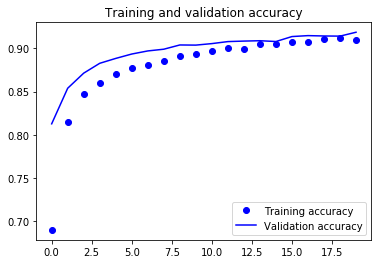

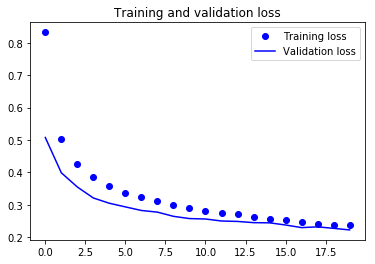

In [40]:
import matplotlib.pyplot as plt

%matplotlib inline
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Classification Report
We can summarize the performance of our classifier as follows

In [50]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

 9888/10000 [============================>.] - ETA: 0s

In [51]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.85      0.88      0.87      1000
    Class 1       0.99      0.99      0.99      1000
    Class 2       0.88      0.89      0.88      1000
    Class 3       0.93      0.95      0.94      1000
    Class 4       0.90      0.87      0.89      1000
    Class 5       0.99      0.98      0.98      1000
    Class 6       0.79      0.75      0.77      1000
    Class 7       0.96      0.96      0.96      1000
    Class 8       0.98      0.99      0.99      1000
    Class 9       0.96      0.98      0.97      1000

avg / total       0.92      0.92      0.92     10000



It's apparent that our classifier is underperforming for class 6 in terms of both precision and recall. For class 2, classifier is slightly lacking precision whereas it is slightly lacking recall (i.e. missed) for class 4.

Perhaps we would gain more insight after visualizing the correct and incorrect predictions.

Here is a subset of correctly predicted classes.

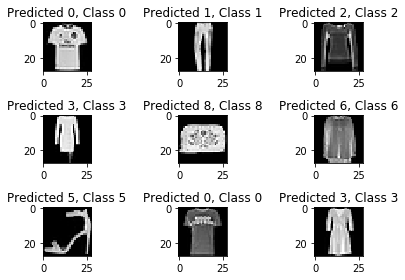

In [52]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()

And here is a subset of incorrectly predicted classes.

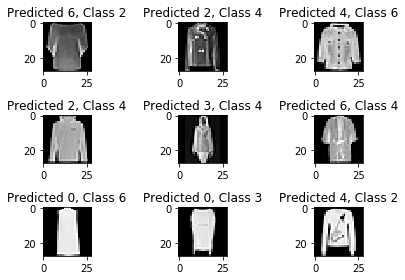

In [18]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()

It looks like diversity of the similar patterns present on multiple classes effect the performance of the classifier although CNN is a robust architechture. A jacket, a shirt, and a long-sleeve blouse has similar patterns: long sleeves (or not!), buttons (or not!), and so on.

#### What do the activations look like?

The snippets are taken from _Chollet, F (2017)_. The idea is the give an input data and visualize the activations of the conv layers.

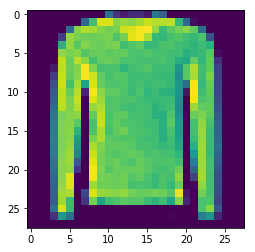

In [19]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

Let's see the activation of the 2nd channel of the first layer:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  This is separate from the ipykernel package so we can avoid doing imports until


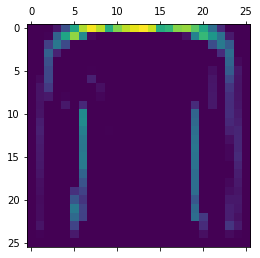

In [20]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

Let's plot the activations of the other conv layers as well.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


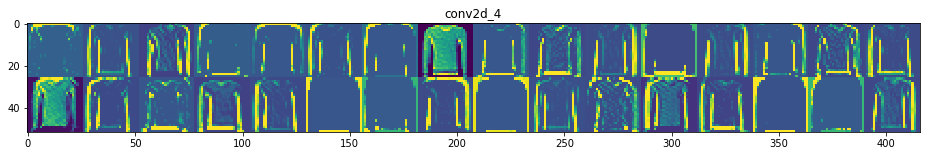

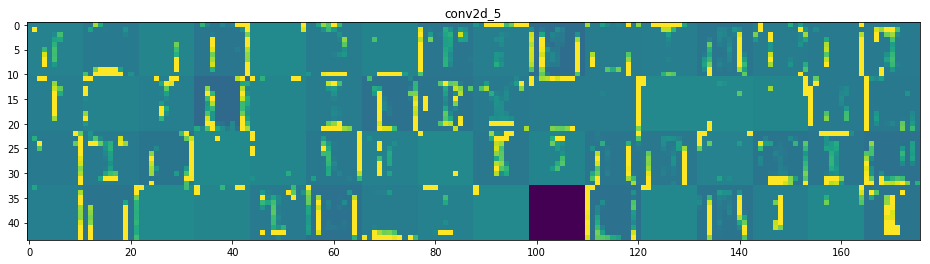

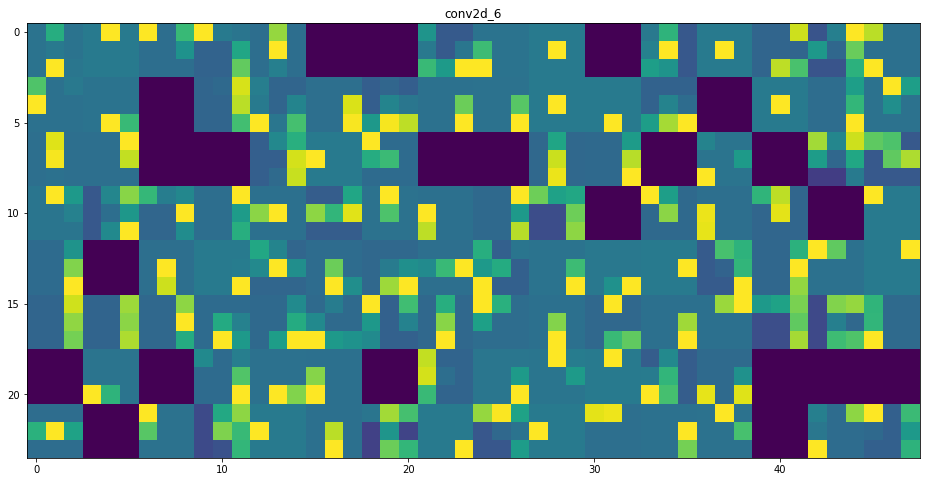

In [21]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')